In [72]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [73]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [83]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [84]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [85]:
TRAIN_SPLIT = 300000
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)

In [86]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

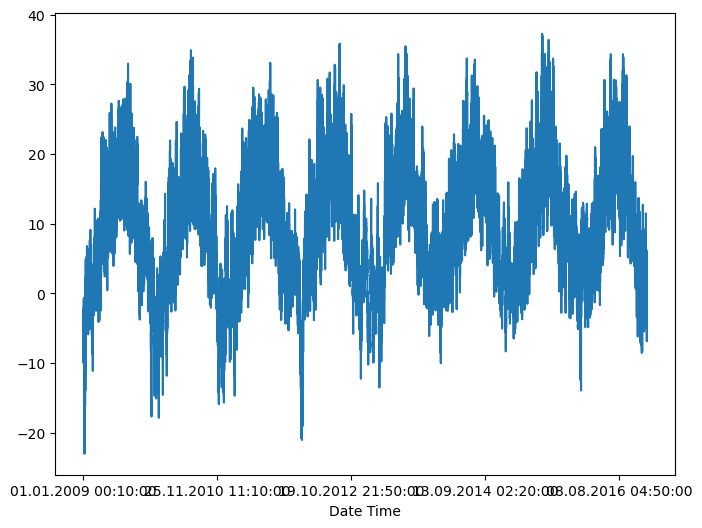

In [87]:
uni_data.plot(subplots=True)

In [88]:
uni_data = uni_data.values

In [89]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
# 데이터를 표준화합시다.
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [90]:
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

In [91]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [92]:
x_train_uni.shape, y_train_uni.shape, x_val_uni.shape, y_val_uni.shape

((299980, 20, 1), (299980,), (120531, 20, 1), (120531,))

In [93]:
print ('Single window of past history')
print (x_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]


In [94]:
print ('\n Target temperature to predict')
print (y_train_uni[0])


 Target temperature to predict
-2.1041848598100876


In [95]:
def create_time_steps(length):
  return list(range(-length, 0))

In [96]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\TJ\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

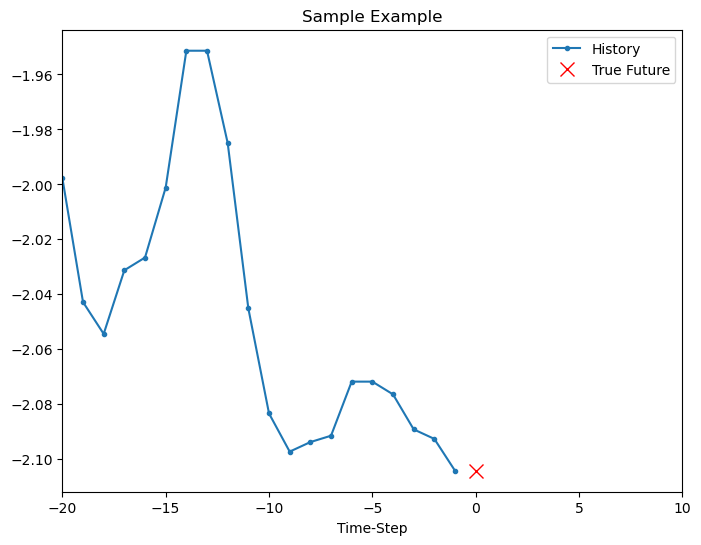

In [97]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [98]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\TJ\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

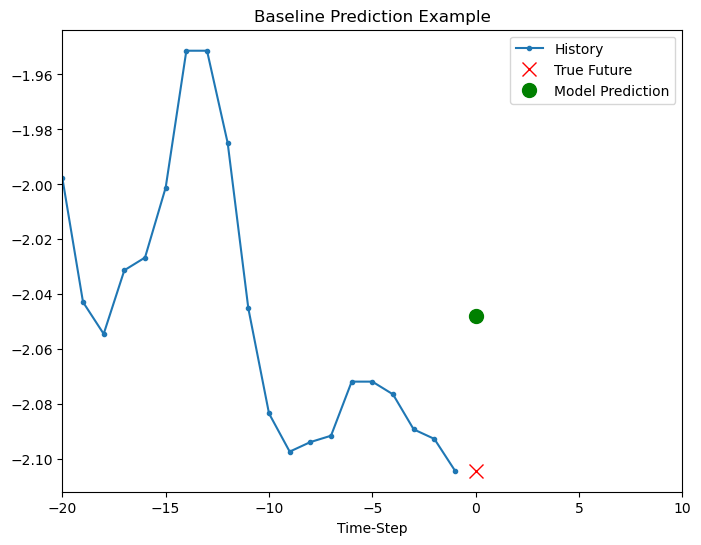

In [99]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [100]:
x_train_uni.shape, y_train_uni.shape, x_val_uni.shape, y_val_uni.shape

((299980, 20, 1), (299980,), (120531, 20, 1), (120531,))

In [101]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
type(val_univariate)

tensorflow.python.data.ops.dataset_ops.RepeatDataset

In [102]:
x_train_uni.shape, y_train_uni.shape, x_val_uni.shape, y_val_uni.shape

((299980, 20, 1), (299980,), (120531, 20, 1), (120531,))

In [107]:
val_univariate.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [103]:
simple_lstm_model = tf.keras.models.Sequential([
      # x_train_uni.shape = (299980, 20, 1)
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [104]:
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [69]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x))
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 2s 7ms/step
[[-0.00994864]
 [-0.0099042 ]
 [-0.00984173]
 [-0.00977346]
 [-0.00972527]
 [-0.00966982]
 [-0.00976786]
 [-0.00986975]
 [-0.00987497]
 [-0.00983816]
 [-0.00983813]
 [-0.00992688]
 [-0.00999314]
 [-0.00995359]
 [-0.00986869]
 [-0.00976768]
 [-0.00962854]
 [-0.00949955]
 [-0.00940233]
 [-0.00925201]
 [-0.0090887 ]
 [-0.00906231]
 [-0.00894612]
 [-0.00876351]
 [-0.00892584]
 [-0.00894086]
 [-0.00884572]
 [-0.00874262]
 [-0.00865668]
 [-0.0085052 ]
 [-0.00827562]
 [-0.0081022 ]
 [-0.00792051]
 [-0.00772325]
 [-0.00756738]
 [-0.00739472]
 [-0.00713696]
 [-0.00695148]
 [-0.00705684]
 [-0.00723028]
 [-0.00752123]
 [-0.00753985]
 [-0.00746959]
 [-0.00736697]
 [-0.00753369]
 [-0.00772887]
 [-0.00780593]
 [-0.00788686]
 [-0.00785227]
 [-0.00760663]
 [-0.00732209]
 [-0.00717169]
 [-0.00708738]
 [-0.00726131]
 [-0.00762303]
 [-0.00784851]
 [-0.00802167]
 [-0.00817753]
 [-0.008319  ]
 [-0.00846611]
 [-0.00854477]
 [-0.00855675]
 [-0.0086172 ]
 [-0

In [70]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 8ms/step - loss: 0.4470 - val_loss: 0.1109
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.1117 - val_loss: 0.0415
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0540 - val_loss: 0.0270
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0438 - val_loss: 0.0219
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0269 - val_loss: 0.0200
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0281 - val_loss: 0.0189
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0253 - val_loss: 0.0179
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0238 - val_loss: 0.0169
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0229 - val_loss: 0.0177
Epoch 10/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0214 - val_loss: 0.0158

8/8 [==============================] - 0s 2ms/step


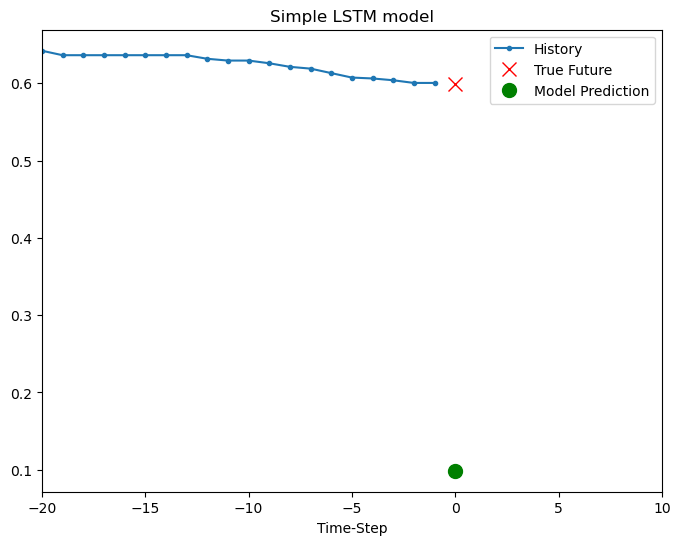

8/8 [==============================] - 0s 2ms/step


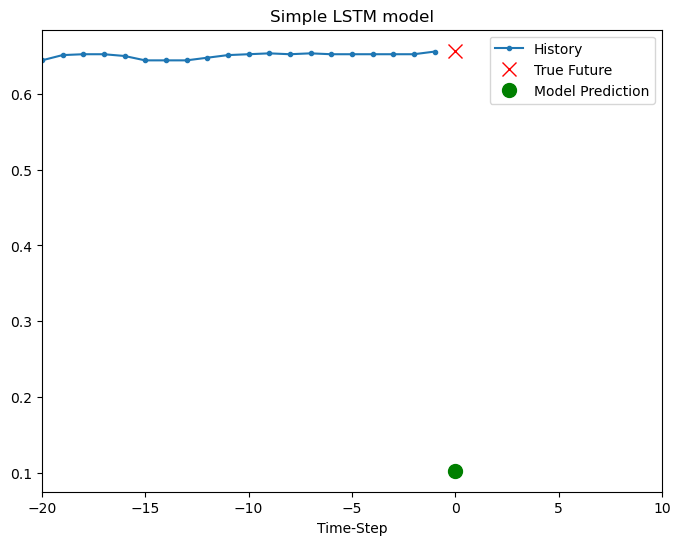

8/8 [==============================] - 0s 2ms/step


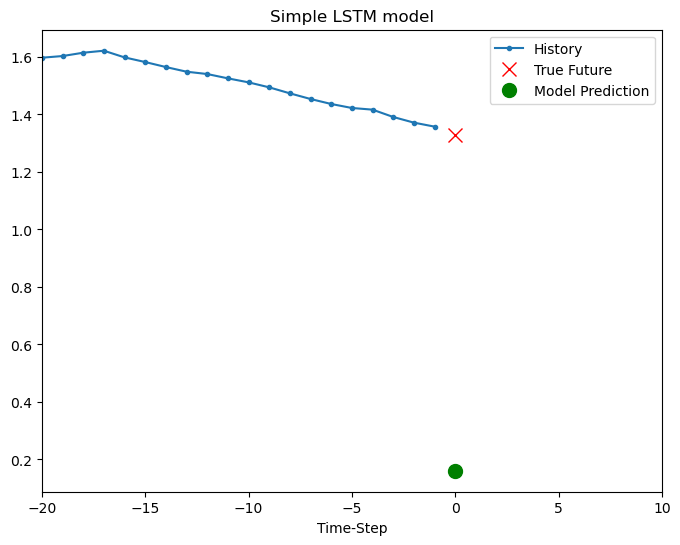

In [110]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()